In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import time 

import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

model_dir = 'modelcp'
checkpoint_path = model_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

defects_folder = 'test_run/defects'
images_1 = 'test_run/images1'
images_2 = 'test_run/images2'
images_3 = 'test_run/images3'

images_4 = 'test_run/images4'
run_4 = 'test_run/run4'

images_5 = 'test_run/images5'
run_5 = 'test_run/run5'

BATCH_SIZE = 28
IMG_WIDTH = 448
IMG_HEIGHT = 448

In [9]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
def create_model(summary=True):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add global average pooling layer
    x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Add L2 regularization
    x = Dropout(0.5)(x)  # Add Dropout layer
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Optional additional Dense layer with L2
    x = Dropout(0.5)(x)  # Add Dropout layer
    predictions = Dense(4, activation='softmax')(x)  # Two output neurons for "defect" and "no defect"

    # Combine the base model and the custom layers into a final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Keep all layers trainable
    for layer in base_model.layers:
        layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1.0e-5)  # Reduce the learning rate
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    if summary:
        print(model.summary())
    return model

In [11]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

# Create a new model instance
loaded_model = create_model(summary=True)

# Load the previously saved weights
loaded_model.load_weights(latest)

loaded_model.summary()

Model: "model_146"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 454, 454, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 224, 224, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [12]:
def show_img(img_array, title):
        plt.title(title)
        # (uncomment to show)
        # plt.imshow(img_array)
        plt.axis("off")
        
        # plt.show()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        
        model.layers[-1].activation = None
        grad_model = tf.keras.models.Model(
                [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
                last_conv_layer_output, preds = grad_model(img_array)
                if pred_index is None:
                        pred_index = tf.argmax(preds[0])
                        print(pred_index.numpy())
                class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0)
        max_val = tf.math.reduce_max(heatmap)

        if pred_index.numpy() == 0 or pred_index.numpy() == 3: 
                heatmap = tf.zeros_like(heatmap)

        elif pred_index.numpy() == 2: 
                if max_val > 0.05: 
                        heatmap = tf.where(heatmap<0.05, 0, heatmap)
                        heatmap = heatmap / max_val
                else: 
                        heatmap = tf.zeros_like(heatmap)
        elif pred_index.numpy() == 1:
                if max_val < 0.05: 
                        heatmap = tf.where(heatmap>0.05, 0, heatmap)
                        heatmap = heatmap / max_val
                else: 
                        heatmap = tf.zeros_like(heatmap)

        print("Max value in heatmap: ", max_val.numpy())

        return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, output_path, alpha=0.4):
        # Load the original image
        img = tf.keras.preprocessing.image.load_img(img_path)
        img = tf.keras.preprocessing.image.img_to_array(img)

        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

        # print(superimposed_img)
        superimposed_img.save(output_path)
        # Display Grad CAM (uncomment to show)
        # show_img(superimposed_img, 'IMAGE OUT: Grad-CAM')

In [13]:
# def make_prediction_and_visualize():
#         val_path = images_1

#         # Randomly choose a class for the test
#         # class_idx = np.random.randint(0, 4)

#         label_mapping = {
#                 0: ('lviv_no_defect', 'NO LVIV DEFECT'),
#                 1: ('open_lviv_box', 'LVIV DEFECT'),
#                 2: ('open_wfl_cover', 'WFL DEFECT'),
#                 3: ('wfl_no_defect', 'NO WFL DEFECT')
#                 # Add more mappings if needed
#         }

#         # folder, actual_label = label_mapping[class_idx]
#         # print(f'ACTUAL LABEL: {actual_label}')
        
#         # folder = os.path.join(val_path, folder)

#         img_paths = os.listdir(val_path)
#         folder_size = len(img_paths)
#         idx = np.random.randint(0, folder_size)
#         img_path = val_path + '/' + img_paths[idx]
#         #os.path.join(folder, img_paths[idx])
#         img = cv2.imread(img_path)
#         show_img(img[:,:,[2,1,0]], 'IMAGE OUT: NO GRAD CAM')
#         img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
#         rescaled_img = img/255.0
#         batch_pred = np.expand_dims(rescaled_img, 0)
#         pred = np.argmax(loaded_model.predict(batch_pred)[0])

#         predicted_label = list(label_mapping.values())[pred][1]
#         print(f'PRED LABEL: {predicted_label}')

#         last_conv_layer_name = 'conv5_block3_out'

#         heatmap = make_gradcam_heatmap(batch_pred, loaded_model, last_conv_layer_name)
#         save_and_display_gradcam(img_path, heatmap)
#         return pred

# make_prediction_and_visualize()

1/1 [==============================] - 0s 384ms/step
file name without extension is 1
PRED LABEL: NO LVIV DEFECT with confidence 1.00
Defect found! Saving images for NO LVIV DEFECT
0
Max value in heatmap:  0.08153649


C:\Users\admin\AppData\Local\Temp\ipykernel_34848\830705968.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 20ms/step
file name without extension is 10
PRED LABEL: NO LVIV DEFECT with confidence 0.99
Defect found! Saving images for NO LVIV DEFECT
0
Max value in heatmap:  0.056801952
1/1 [==============================] - 0s 18ms/step
file name without extension is 100
PRED LABEL: NO LVIV DEFECT with confidence 0.99
Defect found! Saving images for NO LVIV DEFECT
0
Max value in heatmap:  0.059847318
1/1 [==============================] - 0s 17ms/step
file name without extension is 101
PRED LABEL: NO LVIV DEFECT with confidence 1.00
Defect found! Saving images for NO LVIV DEFECT
0
Max value in heatmap:  0.05628861
1/1 [==============================] - 0s 18ms/step
file name without extension is 102
PRED LABEL: NO LVIV DEFECT with confidence 0.99
Defect found! Saving images for NO LVIV DEFECT
0
Max value in heatmap:  0.06470059
1/1 [==============================] - 0s 18ms/step
file name without extension is 103
PRED LABEL: NO LVIV DEFECT with confiden

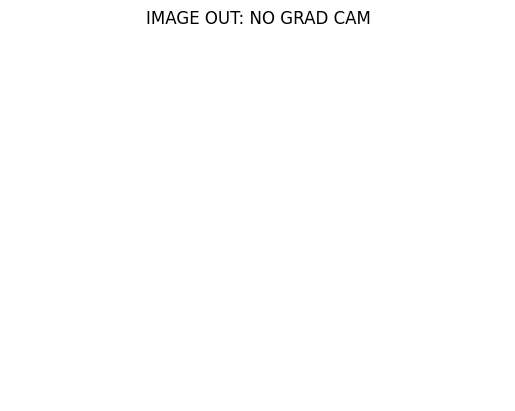

In [14]:
def make_prediction_and_visualize():
    val_path = images_5
    poses_csv_path = os.path.join(val_path, "poses.csv")
    poses_df = pd.read_csv(poses_csv_path, header=None) 

    # Define the label mapping
    label_mapping = {
        0: ('lviv_no_defect', 'NO LVIV DEFECT'),
        1: ('open_lviv_box', 'LVIV DEFECT'),
        2: ('open_wfl_cover', 'WFL DEFECT'),
        3: ('wfl_no_defect', 'NO WFL DEFECT')
    }

    confidence_threshold = 0.91
    count = 0
    curr_location = None
    curr_defect = None
    prev_defect = None

    # Loop over all images in the images folder
    img_paths = os.listdir(val_path)
    for img_name in img_paths:
        filename_without_extension = os.path.splitext(img_name)[0]
        if img_name.endswith(('.png', '.jpg', '.jpeg')) and int(filename_without_extension)!=0: 
            img_path = os.path.join(val_path, img_name)

            # Read and display the original image
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            rescaled_img = img_resized / 255.0
            batch_pred = np.expand_dims(rescaled_img, 0)

            # Predict the label
            pred_probs = loaded_model.predict(batch_pred)[0]
            pred = np.argmax(pred_probs)
            confidence_score = pred_probs[pred]
            predicted_label = list(label_mapping.values())[pred][1]

            # If the label is 1 or 2, save the image and Grad-CAM
            # confidence_score >= confidence_threshold and 
            if pred >= 0:

                print(f"file name without extension is {filename_without_extension}")
                row_index = int(filename_without_extension)
                value_from_csv = poses_df.iloc[row_index, 0] 

                if -80 <= value_from_csv < -55:
                    carriage_num = "DT2"
                elif -55 <= value_from_csv < -32:
                    carriage_num = "MP2"
                elif -32 <= value_from_csv < -10:
                    carriage_num = "MI2" 
                elif -10 <= value_from_csv < 12:
                    carriage_num = "MI1" 
                elif 12 <= value_from_csv < 35:
                    carriage_num = "MP1" 
                elif 35 <= value_from_csv < 60:
                    carriage_num = "DT1" 
                
                show_img(img[:, :, [2, 1, 0]], 'IMAGE OUT: NO GRAD CAM')
                print(f'PRED LABEL: {predicted_label} with confidence {confidence_score:.2f}')
                print(f"Defect found! Saving images for {predicted_label}")

                # Save the original image to the defects folder
                new_file_name = f"{predicted_label}_{filename_without_extension}_{curr_location}.jpg"
                original_image_save_path = os.path.join(run_5, new_file_name)
                cv2.imwrite(original_image_save_path, img)

                # Generate Grad-CAM heatmap
                last_conv_layer_name = 'conv5_block3_out'
                heatmap = make_gradcam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

                # Save the image with Grad-CAM superimposed to the defects folder
                gradcam_image_save_path = os.path.join(run_5, f"{os.path.splitext(new_file_name)[0]}_gradcam.png")
                save_and_display_gradcam(img_path, heatmap, gradcam_image_save_path)
                count += 1 
                curr_defect = predicted_label
                curr_location = carriage_num

                # if (count == 40) and (curr_defect != prev_defect):  
                #     prev_defect = curr_defect

                #     show_img(img[:, :, [2, 1, 0]], 'IMAGE OUT: NO GRAD CAM')
                #     print(f'PRED LABEL: {predicted_label} with confidence {confidence_score:.2f}')
                #     print(f"Defect found! Saving images for {predicted_label}")
                #     print(f"Value from CSV for image {filename_without_extension}: {value_from_csv}")

                #     # Save the original image to the defects folder
                #     new_file_name = f"{predicted_label}_{filename_without_extension}_{curr_location}.jpg"
                #     original_image_save_path = os.path.join(defects_folder, new_file_name)
                #     cv2.imwrite(original_image_save_path, img)

                #     # Generate Grad-CAM heatmap
                #     last_conv_layer_name = 'conv5_block3_out'
                #     heatmap = make_gradcam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

                #     # Save the image with Grad-CAM superimposed to the defects folder
                #     gradcam_image_save_path = os.path.join(defects_folder, f"{os.path.splitext(new_file_name)[0]}_gradcam.png")
                #     save_and_display_gradcam(img_path, heatmap, gradcam_image_save_path)
                
                # elif count>40: 
                #     if curr_defect != prev_defect: 
                #         count = 0
            # elif confidence_score < confidence_threshold and pred in [1, 2]:
            #     print(f"Skipping {img_name}: Confidence {confidence_score:.2f} below threshold.")
            else:
                print("No defect found")

    print("All images scanned!")

# Call the modified function
make_prediction_and_visualize()